# Geochemical Facies Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import pylab as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

## Data Import, cleaning and exploration

In [2]:
geochem_df = pd.read_excel('Geochem_Enthought_02_02_2017.xlsx')
# delete the first row that has units
geochem_df.drop(geochem_df.index[0], inplace=True)

#drop some repeated columns
geochem_df.drop('Well Name', 1, inplace=True)
geochem_df.drop('Stop Depth (ftMD)', 1, inplace=True)
geochem_df.drop('Total', 1, inplace=True)
geochem_df.drop('Sum', 1, inplace=True)

In [3]:
#drop empty rows
geochem_df = geochem_df[pd.notnull(geochem_df['Quartz'])]
print(geochem_df.shape)

(498, 84)
(494, 84)


In [4]:
cols = geochem_df.columns.tolist()
# remove whitespace from column names
cols = map(lambda s: s.strip(), cols)
geochem_df.columns = cols
#move 2nd Well name and Depth columns to leftmost
cols.insert(0, cols.pop(cols.index('Well')))
cols.insert(1, cols.pop(cols.index('Depth')))
geochem_df = geochem_df[cols]


In [5]:
#convert all numeric columns, nan if missing data
for col in  geochem_df.columns[1:]:
    geochem_df[col] = pd.to_numeric(geochem_df[col], errors='coerce')


In [6]:
#drop all nan columns and rows
geochem_df.dropna(axis=1, how='all', inplace=True)
geochem_df.dropna(axis=0, how='all', inplace=True)


In [7]:
geochem_df['Well'] = geochem_df['Well'].str.strip()
#geochem_df.drop('Sample Type', 1, inplace=True)

geochem_df['Si/Zr'] = geochem_df['SiO2'] / geochem_df['Zr']
geochem_df['Si/Al'] = geochem_df['SiO2'] / geochem_df['Al2O3']
geochem_df['Zr/Al'] = geochem_df['Zr'] / geochem_df['Al2O3']

In [8]:
columns = [u'Well', u'Depth', u'Facies Code', u'Quartz', u'K-Feldspar',
       u'Plagioclase', u'Total Feldspar',
       u'IlliteSmectiteMica', u'Total Clay', u'Calcite', u'Ankerite/Dolomite', u'Total Carbonate',
       u'Pyrite', u'Organics', u'Al2O3', u'SiO2', u'TiO2', 
       u'Fe2O3', u'MnO', u'MgO', u'CaO', u'Na2O', u'K2O',
       u'P2O5', u'SO3', u'Cl', u'Zr', 'Si/Zr', 'Si/Al',
       'Zr/Al'
       ]

geochem_df = geochem_df[columns]

# interpolate remaining missing values
geochem_df = geochem_df.interpolate().reset_index()

In [9]:
geochem_df

,index,Well,Depth,Facies Code,Quartz,K-Feldspar,Plagioclase,Total Feldspar,IlliteSmectiteMica,Total Clay,...,CaO,Na2O,K2O,P2O5,SO3,Cl,Zr,Si/Zr,Si/Al,Zr/Al
0,1,Hughes 1H-1918X,11660,19.0,27.558190,0.395184,8.167913,8.563097,20.734070,26.191496,...,19.485203,0.782280,1.192401,0.197497,1.203006,0.27550,201.698178,0.209418,5.811836,27.752344
1,2,Hughes 1H-1918X,11690,2.0,42.917287,0.640922,9.633021,10.273943,15.605936,19.706967,...,15.523925,0.926904,1.005338,0.192058,0.808247,0.26470,395.346318,0.126898,9.870668,77.784505
2,3,Hughes 1H-1918X,11720,2.0,44.547738,0.563385,10.072429,10.635814,15.170980,19.503969,...,15.523925,0.874313,0.979329,0.177147,0.757809,0.23050,362.698941,0.129336,9.291465,71.839757
3,4,Hughes 1H-1918X,11750,2.0,42.645552,0.375865,9.037936,9.413801,14.559154,18.583783,...,15.464447,0.867739,1.048352,0.221692,0.963554,0.25680,410.104721,0.117387,9.210900,78.466400
4,5,Hughes 1H-1918X,11780,2.0,42.610581,1.261267,8.954202,10.215469,15.533044,19.194292,...,18.652502,0.815149,1.057355,0.253295,1.156314,0.24470,401.495652,0.113999,9.146188,80.230503
5,6,Hughes 1H-1918X,11810,2.0,40.134195,1.103486,9.936477,11.039963,14.621931,18.052150,...,19.235393,0.834871,1.188399,0.291838,1.268176,0.22990,393.781032,0.116386,7.631634,65.571771
6,7,Hughes 1H-1918X,11840,2.0,40.317316,5.203118,7.723244,12.926363,10.761529,13.558449,...,27.752734,0.624509,1.071360,0.133071,1.195765,0.30170,238.035156,0.164481,7.031265,42.748240
7,8,Hughes 1H-1918X,11870,14.0,36.019415,0.081396,8.869430,8.950826,14.614197,18.619876,...,22.399656,0.749411,1.042350,0.195434,1.308126,0.28190,433.360387,0.100356,8.402742,83.729699
8,9,Hughes 1H-1918X,11900,16.0,36.477085,0.255660,8.624007,8.879667,16.106384,20.095370,...,20.341695,0.661323,1.126378,0.207062,1.250697,0.25780,337.654378,0.117776,8.185590,69.501324
9,10,Hughes 1H-1918X,11930,14.0,32.508773,0.413578,8.887683,9.301260,13.746146,17.669275,...,23.446480,0.762559,1.152387,0.182023,1.293644,0.28280,368.512857,0.115223,7.132140,61.898611


## Dimensionality reduction

-explain the variability in the data
-express the data as a relationship between underlying variables

FactorAnalysis performs a maximum likelihood estimate of the so-called loading matrix, the transformation of the latent variables to the observed ones, using expectation-maximization (EM).



In [10]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        print(summary)
        return summary

def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

def pca_scatter(pca, standardised_values, classifs):
    comps = pca.transform(standardised_values)
    comp_df = pd.DataFrame(zip(comps[:, 0], comps[:, 1], classifs), columns=["PC1", "PC2", "Well"])
    sns.lmplot("PC1", "PC2", comp_df, hue="Well", fit_reg=False)
    plt.show()

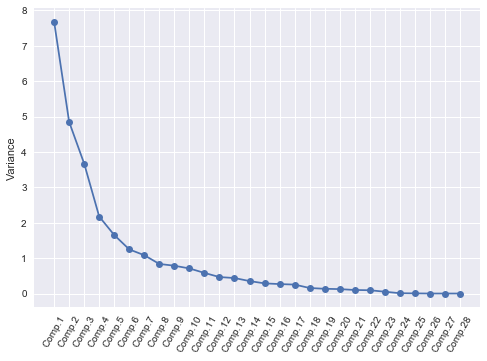

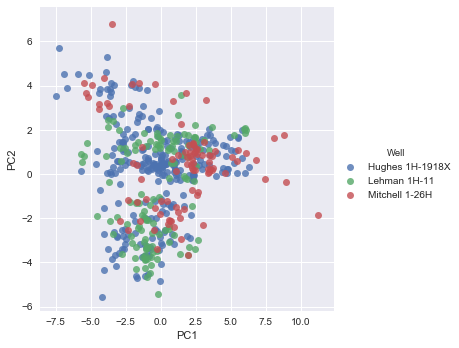

In [11]:
data = geochem_df.ix[:, 3:]
data = scale(data)
pca = PCA()
pca.fit(data)

screeplot(pca, data)

pca_scatter(pca, data, geochem_df['Well'].values)

In [27]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components = 7, tol=1e-8, max_iter=1000000)
fa.fit(data)

fa_data = fa.transform(data)

fa_df = pd.DataFrame(fa_data, columns=['Comp {}'.format(i) for i in range(0,7)])
fa_df['Well'] = geochem_df['Well']
fa_df['Depth'] = geochem_df['Depth']
kmeans = KMeans(n_clusters=7, random_state=0).fit(fa_data)

fa_df['FAFacies'] = kmeans.labels_

factors =  pd.DataFrame(fa.components_, columns=geochem_df.ix[:, 3:].columns.values)
print(factors)

   Facies Code    Quartz    K-Feldspar   Plagioclase  Total Feldspar  \
0     0.383056 -0.551259 -5.436791e-01 -5.366125e-01   -7.679291e-01   
1     0.003270  0.418847  4.180384e-01 -8.341152e-01   -5.786677e-01   
2     0.207298  0.066324 -7.265727e-01  9.207100e-02   -2.674191e-01   
3    -0.066294 -0.009668  4.182173e-02 -8.844077e-02   -6.257432e-02   
4     0.541904 -0.707395  6.355495e-10  1.875825e-10    4.853508e-10   
5    -0.092094 -0.032214  6.248094e-12  3.150209e-12    5.996257e-12   
6     0.015714 -0.011447  1.644587e-14 -3.229181e-12   -3.020281e-12   

   IlliteSmectiteMica  Total Clay       Calcite  Ankerite/Dolomite  \
0           -0.373040   -0.387735  8.775883e-01       3.781870e-01   
1            0.438126    0.372536 -2.783007e-01      -4.538851e-01   
2            0.482584    0.495201 -2.953099e-01      -1.332337e-01   
3            0.059973    0.061623 -2.553027e-01       7.957460e-01   
4            0.647862    0.679125  9.424772e-10       2.873515e-10   
5  

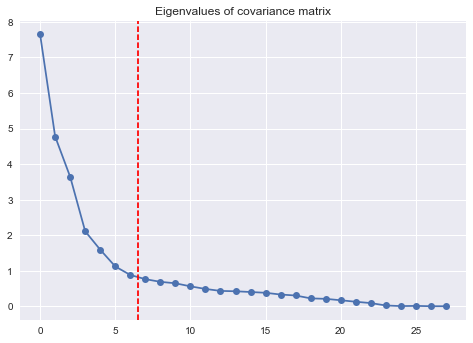

In [28]:
plt.plot(np.linalg.eig(fa.get_covariance())[0], 'o-')
plt.title('Eigenvalues of covariance matrix')
plt.axvline(x=6.5, color='r', linestyle='--')

At the intersection of each factor and feature, a positive number indicates that a positive proportion exists between the two; a negative number, instead, points out that they diverge and one is the contrary to the other.

We can examine the relationship between factors and the observed features.  A positive number suggests that the observation of a feature is correlated to the presence of an underlying factor.  A negative number suggests the the opposite.    For example, the first factor (Factor 0) is strongly associated with K-Feldspar, Plagioclase, TiO2 and Zirconium

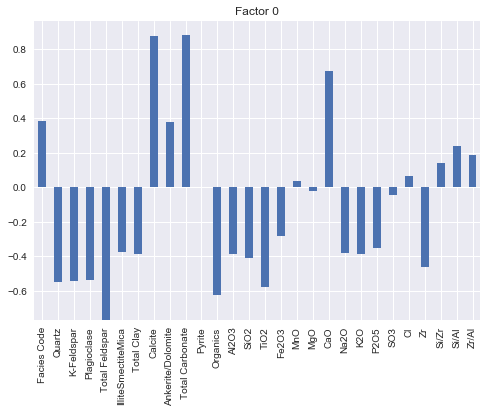

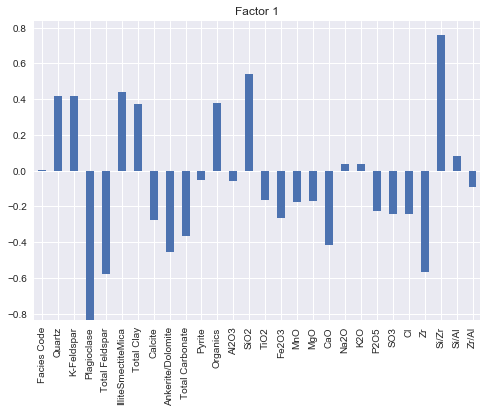

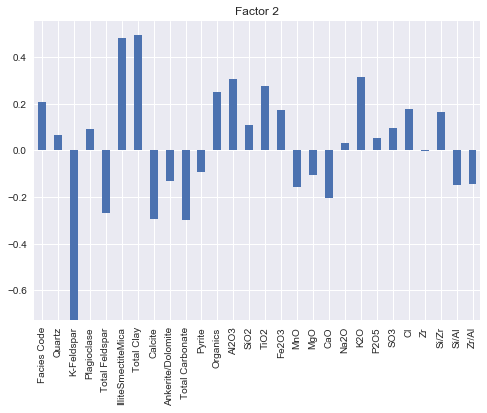

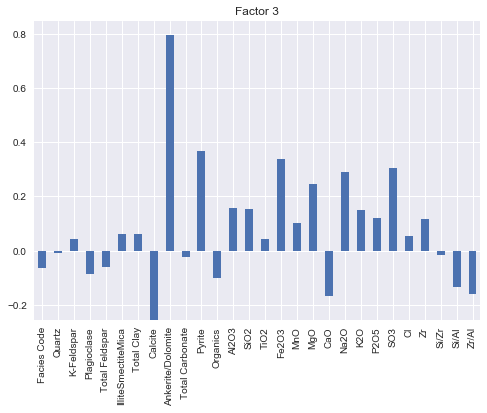

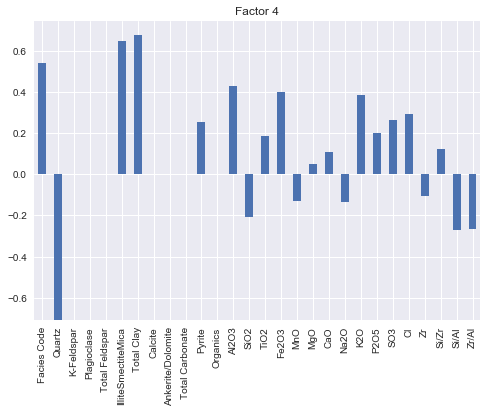

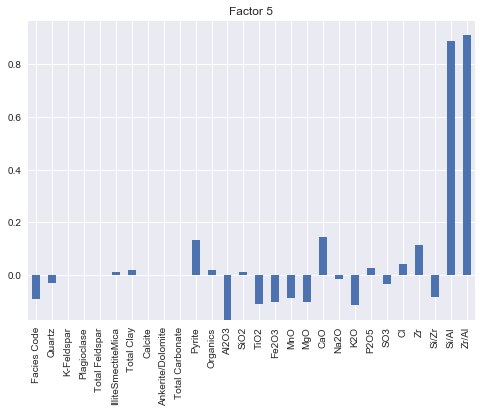

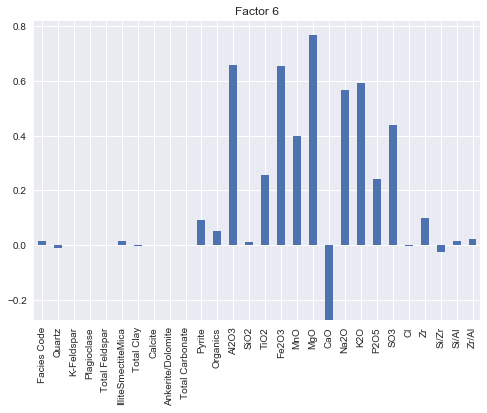

In [29]:
for factor_id in range(0, factors.shape[0]):
    plt.figure()
    plt.title('Factor {}'.format(factor_id))
    factors.ix[factor_id].plot(kind='bar')

In [179]:
comp_data = pca.transform(data)[:,:7]
pca_df = pd.DataFrame(comp_data, columns=['Comp {}'.format(i) for i in range(0,7)])
pca_df['Well'] = geochem_df['Well']
pca_df['Depth'] = geochem_df['Depth']
kmeans = KMeans(n_clusters=7, random_state=0).fit(comp_data)

pca_df['PCAFacies'] = kmeans.labels_

pca_df

,Comp 0,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Well,Depth,PCAFacies
0,-1.861588,3.937354,3.693816,-2.014104,1.933891,-1.442602,-0.756925,Hughes 1H-1918X,11660,3
1,-2.681640,1.130176,-1.197121,-2.606369,1.943485,-1.544547,-2.042972,Hughes 1H-1918X,11690,3
2,-2.316805,1.009718,-1.339131,-2.728754,1.082590,-0.805019,-2.479260,Hughes 1H-1918X,11720,3
3,-2.699594,1.367610,-1.064788,-2.646650,1.686262,-0.732634,-2.445180,Hughes 1H-1918X,11750,3
4,-2.795397,1.454379,-1.111890,-2.539123,1.829325,-0.877466,-1.829138,Hughes 1H-1918X,11780,3
5,-2.861940,2.730658,-0.891701,-2.271281,1.769088,-1.229638,-1.249154,Hughes 1H-1918X,11810,3
6,-0.660548,2.507687,-0.764212,-1.694093,0.256814,-1.528211,-1.268441,Hughes 1H-1918X,11840,3
7,-1.268556,3.051565,0.633801,-2.961836,2.210912,-1.218919,-1.869580,Hughes 1H-1918X,11870,3
8,-1.543687,2.707999,1.232327,-2.888038,1.925161,-1.001447,-1.160044,Hughes 1H-1918X,11900,3
9,-0.982010,3.806248,1.242884,-2.522569,1.993282,-1.510875,-1.355345,Hughes 1H-1918X,11930,3


# Clustering

In [180]:
facies_colors = ['#DA9F8A', '#E48C50','#8E8E68','#88A64C',
       '#5FBBB1','#00A7CB', '#3974AA']

In [181]:
def make_facies_log_plot(logs, facies_colors, label):
    #make sure logs are sorted by depth 
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs['Zr'], logs.Depth, '-g')
    ax[1].plot(logs['Zr/Al'], logs.Depth, '-')
    ax[2].plot(logs['Si/Al'], logs.Depth, '-', color='0.5')
    ax[3].plot(logs['Al2O3'], logs.Depth, '-', color='r')
    ax[4].plot(logs['Quartz'], logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((16*' ').join(['Clust 1', 'Clust 2', 'Clust 3', 
                                'Clust 4', 'Clust 5', 'Clust 6', 'Clust 7']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("Zr")
    ax[0].set_xlim(logs['Zr'].min(),logs['Zr'].max())
    ax[1].set_xlabel("Zr/Al")
    ax[1].set_xlim(logs['Zr/Al'].min(),logs['Zr/Al'].max())
    ax[2].set_xlabel("Si/Al")
    ax[2].set_xlim(logs['Si/Al'].min(),logs['Si/Al'].max())
    ax[3].set_xlabel("Al2O3")
    ax[3].set_xlim(logs['Al2O3'].min(),logs['Al2O3'].max())
    ax[4].set_xlabel("Quartz")
    ax[4].set_xlim(logs['Quartz'].min(),logs['Quartz'].max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well'], fontsize=14,y=0.94)
    return f

In [182]:
geochem_df['Al2O3']

0       7.267789
1       5.082584
2       5.048722
3       5.226501
4       5.004277
5       6.005344
6       5.568303
7       5.175707
8       4.858244
9       5.953492
10      8.277322
11      5.013801
12      5.343962
13      4.611681
14      4.741841
15      2.303724
16      2.402173
17      3.473530
18      4.404605
19      6.429382
20      9.851692
21      6.212132
22      6.776984
23      5.012907
24      4.297842
25      4.129007
26      4.919800
27      6.938370
28     10.954606
29      7.055065
         ...    
464     2.309968
465     1.611721
466     2.162186
467     1.985640
468     2.523211
469     1.631558
470     1.520473
471     1.442118
472     1.919188
473     1.532375
474     1.179284
475     1.319132
476     1.129692
477     0.952453
478     1.484767
479     3.406930
480     3.174842
481     2.080856
482     8.826523
483     0.781660
484     1.928114
485     1.368723
486     2.344682
487     0.951163
488     3.385110
489     2.342698
490     1.300287
491     2.1780

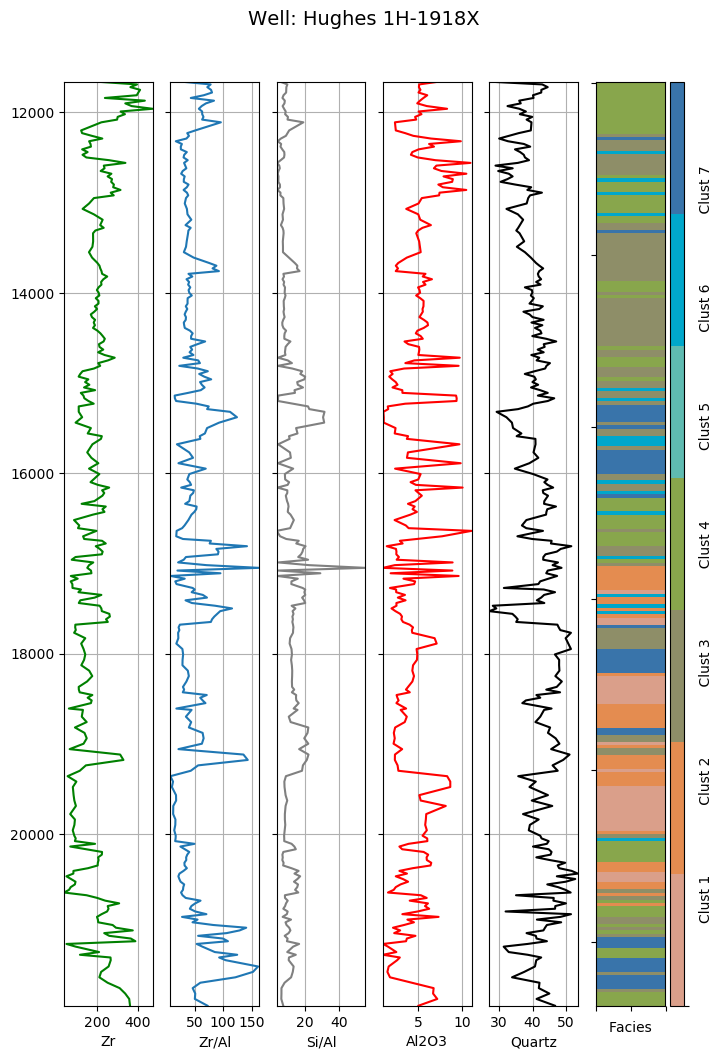

In [183]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

geochem_df['PCAFacies'] = pca_df['PCAFacies']
f = make_facies_log_plot(geochem_df[geochem_df['Well'] == 'Hughes 1H-1918X'],
        facies_colors, 'PCAFacies')


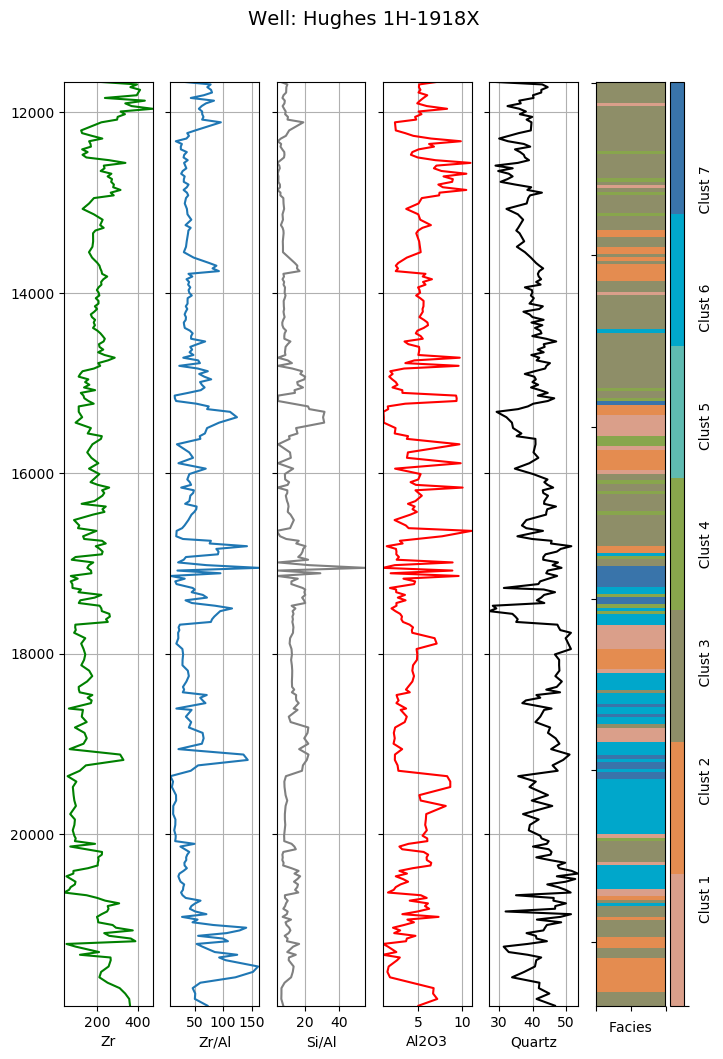

In [184]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

geochem_df['FAFacies'] = fa_df['FAFacies']
f = make_facies_log_plot(geochem_df[geochem_df['Well'] == 'Hughes 1H-1918X'],
        facies_colors, 'FAFacies')


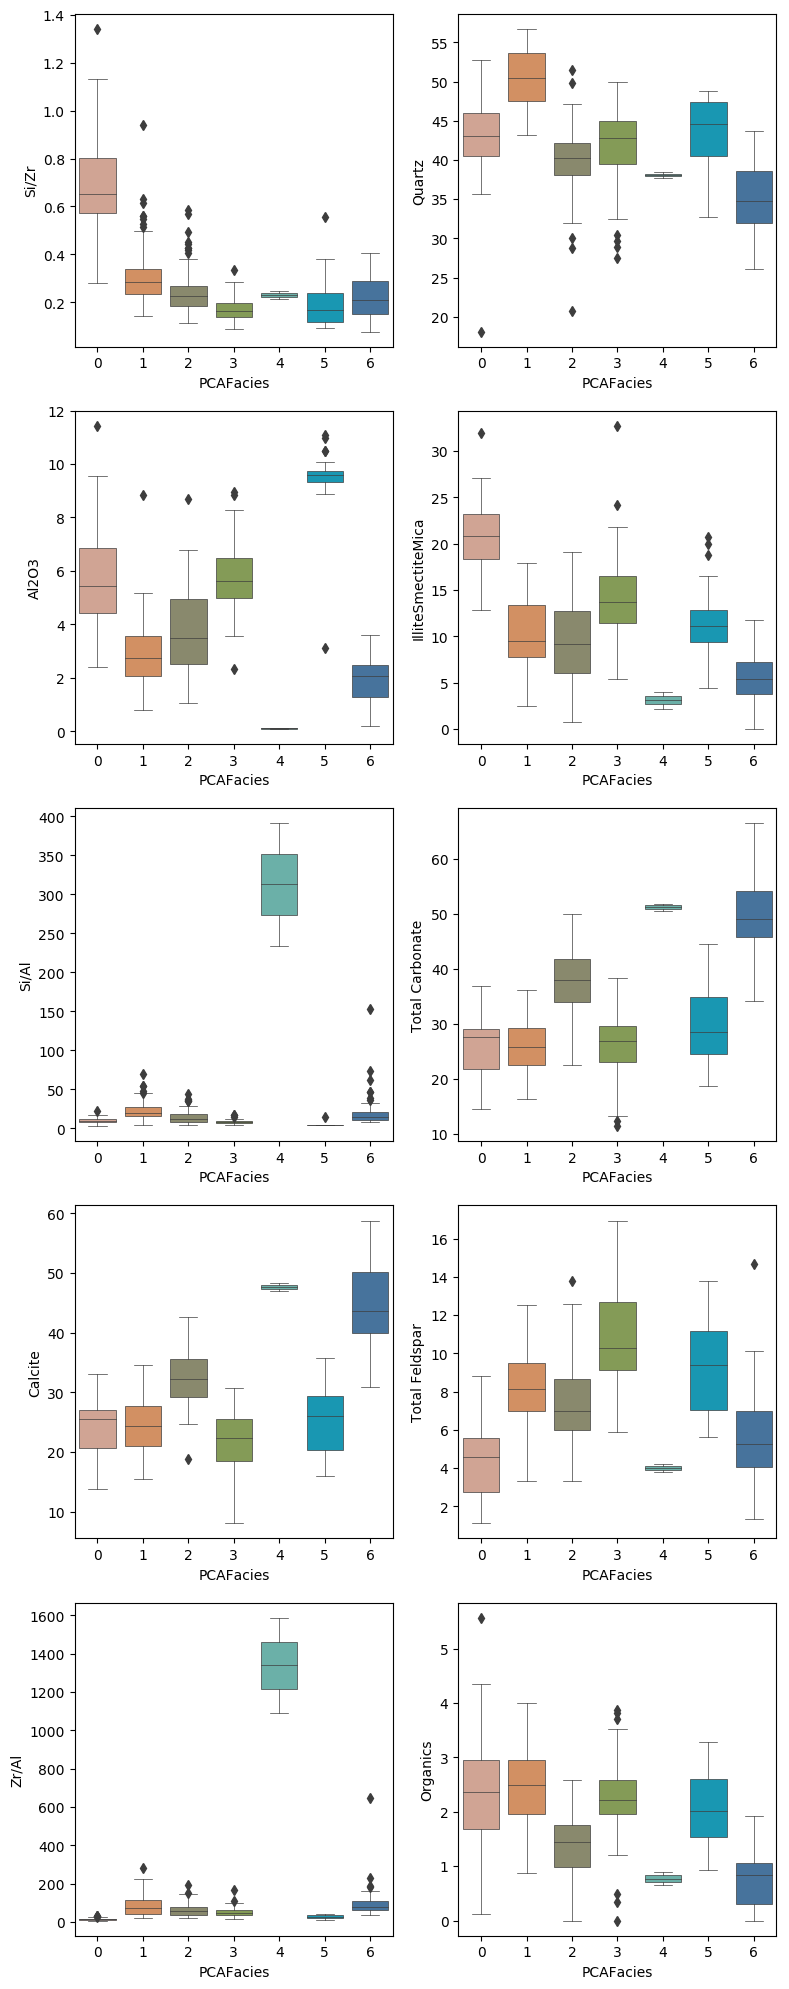

In [185]:
fig, ax = plt.subplots(5,2, figsize=(8,20))
sns.boxplot(x='PCAFacies', y='Si/Zr', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Al2O3', linewidth=0.5,
            data=geochem_df,ax=ax[1,0],
            palette=facies_colors)  
sns.boxplot(x='PCAFacies', y='Si/Al', linewidth=0.5,
            data=geochem_df, ax=ax[2,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Calcite', linewidth=0.5,
            data=geochem_df, ax=ax[3,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Zr/Al', linewidth=0.5,
            data=geochem_df, ax=ax[4,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Quartz', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Total Carbonate', linewidth=0.5,
            data=geochem_df, ax=ax[2,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Total Feldspar', linewidth=0.5,
            data=geochem_df, ax=ax[3,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Organics', linewidth=0.5,
            data=geochem_df, ax=ax[4,1],
            palette=facies_colors)
plt.tight_layout()

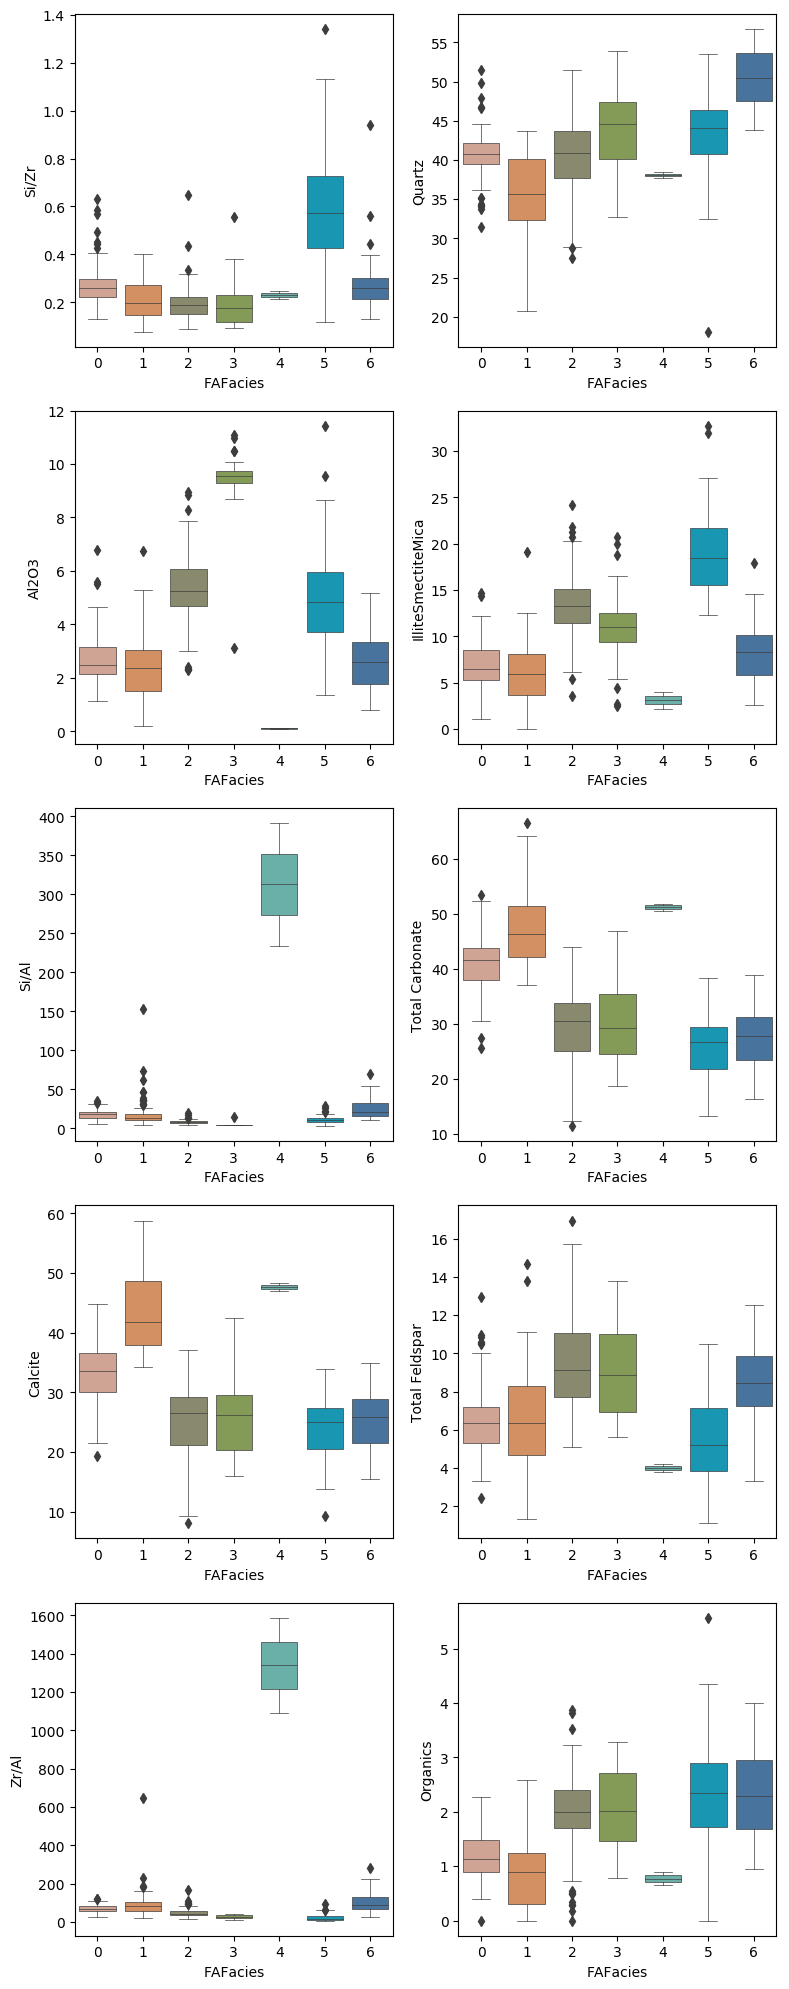

In [186]:
fig, ax = plt.subplots(5,2, figsize=(8,20))
sns.boxplot(x='FAFacies', y='Si/Zr', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Al2O3', linewidth=0.5,
            data=geochem_df,ax=ax[1,0],
            palette=facies_colors)  
sns.boxplot(x='FAFacies', y='Si/Al', linewidth=0.5,
            data=geochem_df, ax=ax[2,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Calcite', linewidth=0.5,
            data=geochem_df, ax=ax[3,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Zr/Al', linewidth=0.5,
            data=geochem_df, ax=ax[4,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Quartz', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Total Carbonate', linewidth=0.5,
            data=geochem_df, ax=ax[2,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Total Feldspar', linewidth=0.5,
            data=geochem_df, ax=ax[3,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Organics', linewidth=0.5,
            data=geochem_df, ax=ax[4,1],
            palette=facies_colors)
plt.tight_layout()

In [187]:
filename = 'well_survey.csv'
hughes_df = pd.read_csv(filename)

In [188]:
# combine the stat facies curve 
filename = 'Hughes_facies.csv'
facies_df = geochem_df[geochem_df['Well'] == 'Hughes 1H-1918X'] # pd.read_csv(filename)

In [164]:
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline
x = hughes_df.MD.values
y = hughes_df.TVD.values
f = interp1d(x,y)
facies_df.loc[:,'TVD'] = f(facies_df.Depth)

/home/brendon/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/brendon/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


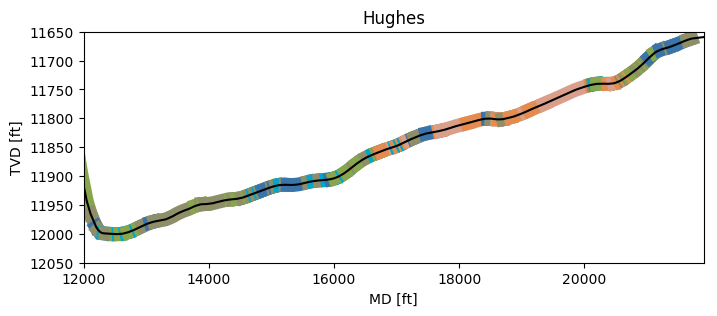

In [165]:
last_row = len(facies_df)
facies_colors = ['#DA9F8A', '#E48C50','#8E8E68','#88A64C',
       '#5FBBB1','#00A7CB', '#3974AA']
plt.figure(figsize=(8,3))

x = []
y = []
for index, row in facies_df.iterrows():
    if index == last_row-1:
        break
    next_row = facies_df.ix[index+1]
    current_facies = row['PCAFacies']
    next_facies = facies_df.ix[index+1, 'PCAFacies']
    #print('current: %d, next: %d\n'%(current_facies, next_facies))
    x.append(row.Depth)
    y.append(row.TVD)
    if current_facies != next_facies:
        x.append(next_row.Depth)
        y.append(next_row.TVD)
        plt.plot(x,y,color=facies_colors[current_facies],linewidth=10)
        x = []
        y = []
plt.xlim([12000, 21905])
plt.ylim([11650, 12050])
plt.gca().invert_yaxis()

plt.plot(facies_df.Depth, facies_df.TVD, color='k',label='Hughes')
plt.title('Hughes')
plt.xlabel('MD [ft]')
plt.ylabel('TVD [ft]')
plt.show()